In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import requests
import math
from termcolor import colored as cl 
import numpy as np

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

In [2]:
def get_historic_data(symbol):
    ticker = symbol
    iex_api_key = 'Tsk_30a2677082d54c7b8697675d84baf94b'
    api_url = f'https://sandbox.iexapis.com/stable/stock/{ticker}/chart/max?token={iex_api_key}'
    df = requests.get(api_url).json()
    
    date = []
    open = []
    high = []
    low = []
    close = []
    
    for i in range(len(df)):
        date.append(df[i]['date'])
        open.append(df[i]['open'])
        high.append(df[i]['high'])
        low.append(df[i]['low'])
        close.append(df[i]['close'])
    
    date_df = pd.DataFrame(date).rename(columns = {0:'date'})
    open_df = pd.DataFrame(open).rename(columns = {0:'open'})
    high_df = pd.DataFrame(high).rename(columns = {0:'high'})
    low_df = pd.DataFrame(low).rename(columns = {0:'low'})
    close_df = pd.DataFrame(close).rename(columns = {0:'close'})
    frames = [date_df, open_df, high_df, low_df, close_df]
    df = pd.concat(frames, axis = 1, join = 'inner')
    return df

msft = get_historic_data('MSFT')
msft = msft.set_index('date')
msft = msft[msft.index >= '2020-01-01']
msft.index = pd.to_datetime(msft.index)

msft.to_csv('msft.csv')
msft = pd.read_csv('msft.csv').set_index('date')
msft.index = pd.to_datetime(msft.index)
msft.tail()

,open,high,low,close
date,,,,
2023-03-20,287.99,287.99,273.69,275.75
2023-03-21,282.07,282.07,278.71,278.71
2023-03-22,283.60,285.74,274.15,274.15
2023-03-23,287.75,291.87,280.25,280.25
2023-03-24,283.59,286.79,282.33,282.33


In [3]:
def sma(data, n):
    sma = data.rolling(window = n).mean()
    return pd.DataFrame(sma)

n = [20, 50]
for i in n:
    msft[f'sma_{i}'] = sma(msft['close'], i)
    
msft.tail()

,open,high,low,close,sma_20,sma_50
date,,,,,,
2023-03-20,287.99,287.99,273.69,275.75,263.0440,258.6082
2023-03-21,282.07,282.07,278.71,278.71,264.2910,259.5244
2023-03-22,283.60,285.74,274.15,274.15,264.9515,260.3430
2023-03-23,287.75,291.87,280.25,280.25,265.9575,261.3532
2023-03-24,283.59,286.79,282.33,282.33,267.2525,262.0586


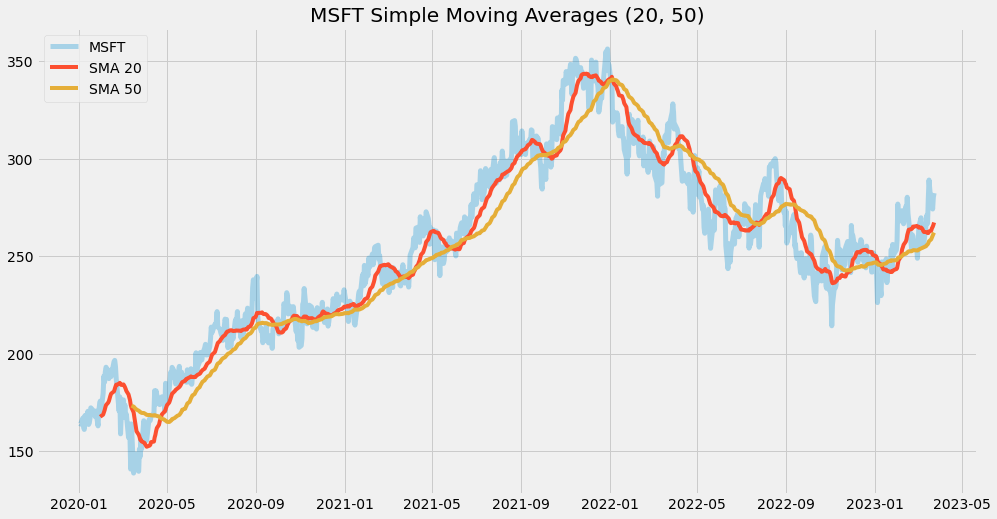

In [4]:
plt.plot(msft['close'], label = 'MSFT', linewidth = 5, alpha = 0.3)
plt.plot(msft['sma_20'], label = 'SMA 20')
plt.plot(msft['sma_50'], label = 'SMA 50')
plt.title('MSFT Simple Moving Averages (20, 50)')
plt.legend(loc = 'upper left')
plt.show()

In [5]:
def implement_sma_strategy(data, short_window, long_window):
    sma1 = short_window
    sma2 = long_window
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    
    for i in range(len(data)):
        if sma1[i] > sma2[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        elif sma2[i] > sma1[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                sma_signal.append(-1)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(0)
            
    return buy_price, sell_price, sma_signal

sma_20 = msft['sma_20']
sma_50 = msft['sma_50']

buy_price, sell_price, signal = implement_sma_strategy(msft['close'], sma_20, sma_50)

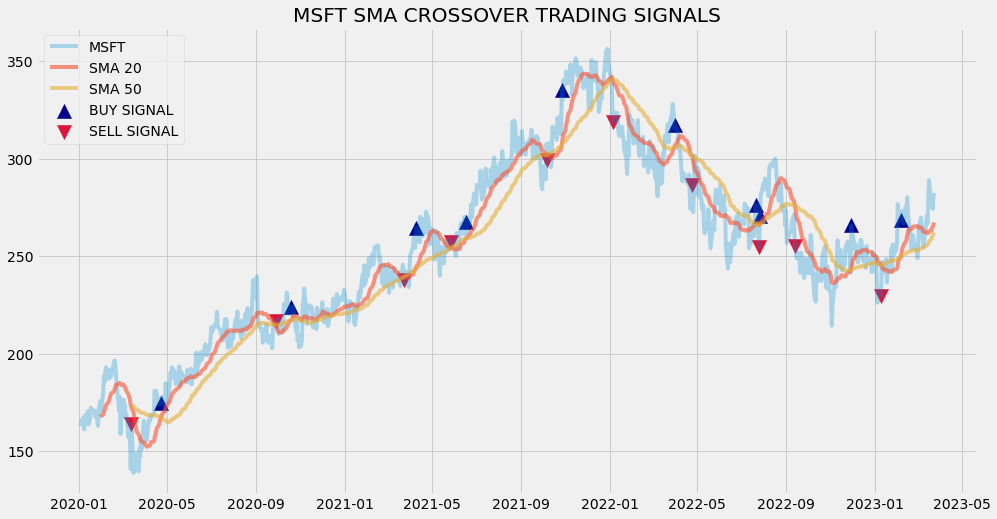

In [6]:
plt.plot(msft['close'], alpha = 0.3, label = 'MSFT')
plt.plot(sma_20, alpha = 0.6, label = 'SMA 20')
plt.plot(sma_50, alpha = 0.6, label = 'SMA 50')
plt.scatter(msft.index, buy_price, marker = '^', s = 200, color = 'darkblue', label = 'BUY SIGNAL')
plt.scatter(msft.index, sell_price, marker = 'v', s = 200, color = 'crimson', label = 'SELL SIGNAL')
plt.legend(loc = 'upper left')
plt.title('MSFT SMA CROSSOVER TRADING SIGNALS')
plt.show()

In [7]:
position = []
for i in range(len(signal)):
    if signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(msft['close'])):
    if signal[i] == 1:
        position[i] = 1
    elif signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
sma_20 = pd.DataFrame(sma_20).rename(columns = {0:'sma_20'})
sma_50 = pd.DataFrame(sma_50).rename(columns = {0:'sma_50'})
signal = pd.DataFrame(signal).rename(columns = {0:'sma_signal'}).set_index(msft.index)
position = pd.DataFrame(position).rename(columns = {0:'sma_position'}).set_index(msft.index)

frames = [sma_20, sma_50, signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy = strategy.reset_index().drop('date', axis = 1)

strategy

,sma_20,sma_50,sma_signal,sma_position
0,NaN,NaN,0,1
1,NaN,NaN,0,1
2,NaN,NaN,0,1
3,NaN,NaN,0,1
4,NaN,NaN,0,1
...,...,...,...,...
808,263.0440,258.6082,0,1
809,264.2910,259.5244,0,1
810,264.9515,260.3430,0,1
811,265.9575,261.3532,0,1


In [8]:
msft_ret = pd.DataFrame(np.diff(msft['close'])).rename(columns = {0:'returns'})
sma_strategy_ret = []

for i in range(len(msft_ret)):
    try:
        returns = msft_ret['returns'][i]*strategy['sma_position'][i]
        sma_strategy_ret.append(returns)
    except:
        pass
    
sma_strategy_ret_df = pd.DataFrame(sma_strategy_ret).rename(columns = {0:'sma_returns'})

investment_value = 100000
number_of_stocks = math.floor(investment_value/msft['close'][1])
sma_investment_ret = []

for i in range(len(sma_strategy_ret_df['sma_returns'])):
    returns = number_of_stocks*sma_strategy_ret_df['sma_returns'][i]
    sma_investment_ret.append(returns)

sma_investment_ret_df = pd.DataFrame(sma_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(sma_investment_ret_df['investment_returns']), 2)
print(cl('Profit gained from the strategy by investing $100K in MSFT : ${} in 1 Year'.format(total_investment_ret), attrs = ['bold']))

Profit gained from the strategy by investing $100K in MSFT : $-16457.8 in 1 Year
